In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm.notebook import tqdm_notebook as tqdm

import seaborn as sns 
pal = sns.color_palette()
import matplotlib.pyplot as plt
%matplotlib inline

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
products=pd.read_csv('../input/learnplatform-covid19-impact-on-digital-learning/products_info.csv')
districts=pd.read_csv('../input/learnplatform-covid19-impact-on-digital-learning/districts_info.csv')
engagement_dir='/kaggle/input/learnplatform-covid19-impact-on-digital-learning/engagement_data'
engagements=pd.DataFrame()
for dir,_,fnames in os.walk(engagement_dir):
    for fname in fnames:
        tmp_df=pd.read_csv(os.path.join(dir,fname))
        tmp_df['district_id']=fname[:-4]
        tmp_df=tmp_df[['district_id','time','lp_id','pct_access','engagement_index']]
        engagements=pd.concat([engagements,tmp_df])


print('ENGAGEMENTS')
display(engagements)
print('PRODUCTS')
display(products)
print('DISTRICTS')
display(districts)

# DATA CLEANSING

## DROP DUPRICATES

In [ ]:
def my_drop_duplicate(df):
    before_len=len(df)
    df.drop_duplicates(inplace=True)
    after_len=len(df)
    diff_len=before_len-after_len
    diff_ratio=diff_len/before_len
    drop_info = {"before_len":before_len,"after_len":after_len,"diff_len":diff_len,"diff_ratio":diff_ratio}
    drop_info = pd.DataFrame([drop_info])
    return df, drop_info

In [4]:
engagements, engagements_drop = my_drop_duplicate(engagements)
products, products_drop = my_drop_duplicate(products)
districts, districts_drop = my_drop_duplicate(districts)

drop_info = pd.concat([engagements_drop,products_drop,districts_drop]).set_axis(['engagements','products','districts'])
drop_info

## NULL DATA

In [5]:
def count_null(df):
    null_count=df.isna().sum()
    null_ratio=null_count/len(df)
    null_info = pd.concat([null_count, null_ratio],axis=1).set_axis(["null_count","null_ratio"],axis=1).round(3)
    return null_info

In [6]:
engagements_null=count_null(engagements)
products_null=count_null(products)
districts_null=count_null(districts)

print('ENGAGEMENTS')
display(engagements_null)
print('PRODUCTS')
display(products_null)
print('DISTRICTS')
display(districts_null)

In [7]:
engagements[engagements['engagement_index'].isnull()]

In [8]:
engamements_dropna=engagements.dropna(subset=['engagement_index'])
engagements_null=count_null(engamements_dropna)
print('ENGAGEMENTS')
display(engagements_null)

In [9]:
products[products['Sector(s)'].isnull()]

In [10]:
districts[districts['state'].isnull()]

__In ENGAGEMENTS, 'pct_access' are missing , when 'engagement_index' is null__

We drop all rows including _Nan_ though some instances only without 'lp_id' exist.
Because the ratio of instances without 'lp_id' is less than 0.0005 even the highest ratio of null is only 0.004.

__In PRODUCTS, 'sector(s)' and 'Primary Essential Function' are missing in the same instances The instance of 'Provider/Company Name' is also missing in the same instance as one that has _NaN_ in 'sector(s)' and 'Primary Essential Function'.__

For convinience of analysis, we drop all rows including _NaN_.
Because the values in the other columns are products' basic info.

__In DISTRICTS, all columns are missing , when 'state' is null__

For convinience of analysis, we drop the rows which 'state' is missing.

_Nan_ s in 'pct_free/reduced', 'county_connections_ratio', and 'pp_total_raw' are still in the Table. 

We will attempt to discover the tendencies for them after we drop the rows which 'state' is missing.

## DROP NULL DATA

In [11]:
engagements.dropna(inplace=True)
products.dropna(inplace=True)
districts.dropna(subset=['state'], inplace=True)

## LOOK UP NULL DATA in DISTRICTS

In [12]:
districts.info()

In [13]:
for state in districts[districts['pp_total_raw'].isnull()]['state'].unique():
    display(districts[districts['state'] == state])

__Every pp_total_raw in the instances is missing, when 'state' of the instances is following:
+ Connecticut
+ Ohio
+ California
+ Arizona
+ North Dakota
+ New Hampshire

We googled the missing values on the internet.
The results of searching are as following.

|State|Amount|Range|URL|
|---|---|---|---|
|Connecticut|17245|\[16000, 18000 \[ | https://edunomicslab.org/connecticut/ |
|Ohio| - | - | https://edunomicslab.org/ohio/ |
|California| - | - |https://edunomicslab.org/california/ |
|Arizona| - | - | https://edunomicslab.org/arizona/ |
|North Dakota| - | - | https://edunomicslab.org/northdakota/ |
|New Hampshire| - | - | https://edunomicslab.org/newhampshire/ |

The values of the other states than Connecticut was not found, though we even look up the pages connected by the hyperlinks in above pages. _If you found the values, please let me know the values and the references. Thank you._

Next, we make up the missing values of Connecticut with the _range_ in above table.

In [14]:
districts.loc[districts['state']=='Connecticut','pp_total_raw'] = '[16000, 18000['
districts[districts['state'] == 'Connecticut'].head()

In [15]:
engagements_null=count_null(engagements)
products_null=count_null(products)
districts_null=count_null(districts)

print('ENGAGEMENTS')
display(engagements_null)
print('PRODUCTS')
display(products_null)
print('DISTRICTS')
display(districts_null)

## Adjustments

In [16]:
# Convert Data Type
engagements['district_id'] = engagements['district_id'].astype('int64')
engagements['lp_id'] = engagements['lp_id'].astype('int64')
# Separate the values in 'Primary Essential Function'
products['Function Main Category']=products['Primary Essential Function'].apply(lambda x : x.split('-')[0])
products['Function Sub Category']=products['Primary Essential Function'].apply(lambda x : x.split('-')[1])

# DATA VISUALISING

## ENGAGEMENTS

In [17]:
engagements['district_id'].dtype

In [18]:
# add 'state' column into engagements
engagements['state']=np.nan
for state in districts['state'].unique():
    district_ids = districts[districts['state']==state]['district_id'].unique()
    for d_id in district_ids:
        engagements.loc[engagements['district_id']==int(d_id), 'state'] = state
engagements

In [19]:
engagements_state_datacount = engagements.state.value_counts()
ax = engagements_state_datacount.plot.bar(figsize=(20, 4), sharex=False)
ax.set_xlabel("state")
ax.set_ylabel("# of instances")

In [20]:
engagements_num_district = engagements.groupby(['state'])['district_id'].nunique().sort_values(ascending=False)
ax = engagements_num_district.plot.bar(figsize=(20, 4), subplots=False)
ax.set_xlabel("state")
ax.set_ylabel("# of district id")

__The number of instances in each state appears to be proportional to the number of districts in each state.__

So,

In [21]:
plt.figure(figsize=(12,8))
for key, df in engagements.groupby(['state'])['district_id','lp_id']:
    # ここで色を指定する。
#     print(engagements[engagements['state']==key].value_counts())
    size = df['lp_id'].nunique()
#     print(df['district_id'].nunique())
#     print(len(engagements[engagements['state']==key]))
    plt.scatter(df['district_id'].nunique(), len(engagements[engagements['state']==key]), label=key, s=size/50)
    plt.legend(title="state").get_frame().set_alpha(0.6)
    plt.tight_layout()
    plt.xlabel("# of district id")
    plt.ylabel("# of instances")


__The number of instances in each state is roughly proportional to the number of districts in each state.__

__The slight discrepancy seems to be caused by the number of unique instances of "lp_id" in a certain district and at a certain time.__

I specified:
+ on the x-axis, the number of districts in each state
+ on the y-axis, the number of data in each state
+ for each plot size, the number of unique instances of "lp_id" 


In [22]:
engagements_num_time = engagements.groupby(['state'])['time'].nunique().sort_values(ascending=False)
# display(engagements_num_time)
ax = engagements_num_time.plot.bar(figsize=(20, 4))
ax.set_xlabel("state")
ax.set_ylabel("# of unique time")

__The number of unique time in each state is constant except for 3 states: Texas, Minnesota, and North Dakota.__

In [23]:
time_series_all = engagements.groupby(['time'])['pct_access','engagement_index'].agg('mean')
time_series_all.plot(figsize=(20, 8), subplots=True)

In [24]:
# # Too Large to Run

# plt.figure(figsize=(12,8),tight_layout=True)
# for key, df in tqdm(engagements.groupby(['time','state'])['pct_access','engagement_index']):
#     plt.plot(df[['pct_access','engagement_index']].mean(), (key[0],key[0]), label=key[1])
#     plt.legend(title="state").get_frame().set_alpha(0.6)
#     plt.tight_layout()
#     plt.xlabel("# of time")
#     plt.ylabel("# of instances")

In [25]:
# # Too Large to Run

# plt.figure(figsize=(12,8),tight_layout=True)
# for key, df in tqdm(engagements.groupby(['time','state','district_id'])['pct_access','engagement_index']):
#     plt.plot(df[['pct_access','engagement_index']].mean(), (key[0],key[0]), label='_'.join(key[1],key[2]))
#     plt.legend(title="state_district").get_frame().set_alpha(0.6)
#     plt.tight_layout()
#     plt.xlabel("# of time")
#     plt.ylabel("# of instances")

## PRODUCTS

In [26]:
products_sector_datacount = products['Sector(s)'].value_counts()
ax = products_sector_datacount.plot.bar(figsize=(20, 4), sharex=False)
ax.set_xlabel("sector")
ax.set_ylabel("# of instances")

In [27]:
products_function_datacount = products.groupby(['Function Main Category','Function Sub Category'])
plt.figure(figsize=(12,8),tight_layout=True)
for key, df in tqdm(products_function_datacount):
    # ここで色を指定する。
    print(key)

__There's a typographical error.__

So, We unify them.

In [28]:
products.replace(' Sites, Resources & Reference ',' Sites, Resources & Reference',inplace=True)
products.replace(' Sites, Resources & References ',' Sites, Resources & Reference',inplace=True)
products.replace(' Study Tools ',' Study Tools',inplace=True)
products.replace(' Data, Analytics & Reporting ',' Data, Analytics & Reporting',inplace=True)
products_function_datacount = products.groupby(['Function Main Category','Function Sub Category'])
plt.figure(figsize=(12,8),tight_layout=True)
for key, df in tqdm(products_function_datacount):
    # ここで色を指定する。
    print(key)

In [29]:
products_function_datacount = products['Function Main Category'].value_counts()
ax = products_sector_datacount.plot.bar(figsize=(20, 4), sharex=False)
ax.set_xlabel("function")
ax.set_ylabel("# of instances")

In [30]:
products_function_datacount = products.groupby(['Function Main Category'])['URL'].count().sort_values(ascending=False)
ax = products_function_datacount.plot.bar(figsize=(20,4))
ax.set_ylabel("# of instances")

In [31]:
products_function_datacount = products.groupby(['Function Main Category','Function Sub Category'])['URL'].count().sort_values(ascending=False)
ax = products_function_datacount.plot.bar(figsize=(20,4))
ax.set_ylabel("# of instances")

In [32]:
products_provider_datacount = products['Provider/Company Name'].value_counts()
ax = products_provider_datacount.plot.bar(figsize=(20, 4), sharex=False)
ax.set_ylabel("Provider/Company Name")
ax.set_ylabel("# of instances")

In [33]:
print('Display only TOP 10')
products_provider_datacount = products['Provider/Company Name'].value_counts()
ax = products_provider_datacount[:10].plot.bar(figsize=(20, 4), sharex=False)
ax.set_ylabel("Provider/Company Name")
ax.set_ylabel("# of instances")

## DISTRICT

In [34]:
import math
def myGroupDisplay(df,group1,group2=None,column=None,title=None, height=8):
    if group2 == None:
        df = df.groupby([group1])[column]
    else:
        df = df.groupby([group1,group2])[column]
    fig = plt.figure(figsize=(20,height))
    for i, (key,grouped_df) in enumerate(df): 
        plt.subplot(math.ceil(len(df.groupｓ)/6), 6, i+1)
        plt.title(key)
        plt.pie(grouped_df.value_counts())
    plt.legend()
    fig.suptitle(title,fontsize=24)
    plt.tight_layout()
    
fontsize=24

In [35]:
districts_locale = districts['locale'].value_counts()
ax = districts_locale.plot.pie(figsize=(20, 4))
ax.set_title('locale', fontsize=fontsize)

myGroupDisplay(districts,'state',group2=None,column='locale',title='locale')

In [36]:
col = 'pct_black/hispanic'
districts_race = districts[col].value_counts()
ax = districts_race.plot.pie(figsize=(20, 4))
ax.set_title(col, fontsize=fontsize)

myGroupDisplay(districts,'locale',group2=None,   column=col,title=f'{col} / locale',         height=4)
myGroupDisplay(districts,'state', group2=None,   column=col,title=f'{col} / state',          height=8)
myGroupDisplay(districts,'locale',group2='state',column=col,title=f'{col} / locale + state', height=16)

In [37]:
col = 'pct_free/reduced'
districts_expendure = districts[col].value_counts()
ax = districts_expendure.plot.pie(figsize=(20, 4))
ax.set_title(col, fontsize=fontsize)

myGroupDisplay(districts,'locale',group2=None,   column=col,title=f'{col} / locale',         height=4)
myGroupDisplay(districts,'state', group2=None,   column=col,title=f'{col} / state',          height=8)
myGroupDisplay(districts,'locale',group2='state',column=col,title=f'{col} / locale + state', height=16)

In [38]:
col = 'county_connections_ratio'
districts_connection = districts[col].value_counts()
ax = districts_connection.plot.pie(figsize=(20, 4))
ax.set_title(col, fontsize=18)

myGroupDisplay(districts,'locale',group2=None,   column=col,title=f'{col} / locale',         height=4)
myGroupDisplay(districts,'state', group2=None,   column=col,title=f'{col} / state',          height=8)
myGroupDisplay(districts,'locale',group2='state',column=col,title=f'{col} / locale + state', height=16)

In [39]:
col = 'pp_total_raw'
districts_expendure = districts[col].value_counts()
ax = districts_expendure.plot.pie(figsize=(20, 4))
ax.set_title(col, fontsize=18)

myGroupDisplay(districts,'locale',group2=None,   column=col,title=f'{col} / locale',         height=4)
myGroupDisplay(districts,'state', group2=None,   column=col,title=f'{col} / state',          height=8)
myGroupDisplay(districts,'locale',group2='state',column=col,title=f'{col} / locale + state', height=16)

# Analysis

## Merge Tables

In [40]:
import gc

def merge_df(engagements, districts, products):
    df = engagements
    df = pd.merge(df, districts, left_on=['district_id','state'], right_on=['district_id','state'])
    df = pd.merge(df, products, left_on=['lp_id'], right_on=['LP ID'])
    df = df.drop('LP ID', axis=1)
    return df

engagements['district_id'] = engagements['district_id'].astype('int64')
df = merge_df(engagements, districts, products)
df


In [41]:
# del engagements, districts, products
# gc.collect()

# os.makedirs('/kaggle/temp', exist_ok=True)
# df.to_csv('/kaggle/temp/merged_df.csv')
# df = pd.read_csv('/kaggle/temp/merged_df.csv')
# df.head()


## Correlations

In [42]:
df['state'].unique()

In [43]:
replace_dict = {'Rural':0, 'Town':1, 'Suburb':2, 'City':3,
                '[0, 0.2[': 0, '[0.2, 0.4[':2, '[0.4, 0.6[':4, '[0.6, 0.8[':6, '[0.8, 1[':8, 
                '[0.18, 1[':1, '[1, 2[':2,
               '[12000, 14000[':12000, '[6000, 8000[':6000, '[18000, 20000[':18000, '[14000, 16000[':14000, '[16000, 18000[':16000, '[8000, 10000[':8000,
               '[10000, 12000[':10000, '[4000, 6000[':4000, '[20000, 22000[':20000, '[32000, 34000[':32000, '[22000, 24000[':22000}
tmp = df.replace(replace_dict, inplace=False)
sns.heatmap(tmp[['time','pct_access','engagement_index','locale','pct_black/hispanic','pct_free/reduced','county_connections_ratio','pp_total_raw']].corr())

In [44]:
tmp[['pct_black/hispanic', 'pct_free/reduced']].corr()

## Pivot Analysis on _'pct_access' and 'engagement_index'_

In [45]:
def myGroupPivotAnalyze(df, col):
    grouped_df = df.groupby(['time',col])['pct_access','engagement_index'].agg('mean').reset_index()
#     display(grouped_df)
    pivot_df = grouped_df.pivot_table(['pct_access','engagement_index'], index='time', columns=col)
#     display(pivot_df)
    pivot_df['pct_access'].plot(figsize=(20, 4), title=f'pct_access / {col}', subplots=False)
    pivot_df['engagement_index'].plot(figsize=(20, 4), title=f'engagement_index / {col}',subplots=False)
        
columns = [
            'state',
           'locale',
           'pct_black/hispanic',
           'pct_free/reduced',
           'county_connections_ratio',
           'pp_total_raw',
#            'Product Name',
           'Sector(s)',
           'Function Main Category',
#            'Primary Essential Function'
          ]

for col in columns:
    myGroupPivotAnalyze(df,col)

## Findings Memo on _'pct_access','engagement_index'_

The following are clearly different in their movements compared to the others:

### 'state'
+ 'Massachusetts', # 0.5 point increase in the second half of the year
+ 'District Of Columbia',# 1.5 points increase in the second half of the year
+ 'North Carolina', # 0.25 points decrease in the second half of the year  
+ 'New Hampshire', # 0.5 point increase in the second half of the year， (engage)200 increase in　the second QUORTER of the year
+ 'Tennessee', #  0.5 point increase in the second half of the year
+ 'Washington', # 0.5 point increase in the second half of the year
+ 'New York', # 1.5 point increase in the second QUORTER of the year, (engage)200 increase in　the second QUORTER of the year
+ 'Arizona', # 1)Temporary sharp rise in August, 2)High value part of the graph in the second half is sharp
        ],     
> note: I ignore the phenomena　which are the decline of the percentages from March to May and the low percentages from May to July, because I did not find out what is the reasons.

### 'locale': 　　　　
+ Rural >> Suburb > City > Town
+ The value of 'Town' is decreasing from the first half of the year to the second half of the year, even though the other values are increasing.

### 'pct_black/hispanic':
+ the first half of the year
    + 0.8-1.0 >> 0.0-0.2 > 0.2-0.4 > 0.6-0.8 > 0.4-0.6
+ the second half of the year
    + 'pct_access': 0.8-1.0 >> 0.0-0.2 > 0.2-0.4 ≒ 0.6-0.8 > 0.4-0.6
    + -> 'pct_access': 0.8-1.0 >> 0.0-0.2 > 0.2-0.4 > 0.6-0.8 ≒ 0.4-0.6
    
    + 'engagement_index': 0.8-1.0 >> 0.0-0.2 > 0.2-0.4 > 0.4-0.6 ≒ 0.6-0.8
    + -> 'engagement_index': 0.8-1.0 >> 0.0-0.2 > 0.2-0.4 > 0.4-0.6 > 0.6-0.8
    
+ Upward trend in general

### 'pct_free/reduced':
+ 0.8-1.0 >> 0.0-0.2 > 0.2-0.4 ≒ 0.4-0.6 > 0.6-0.8
+ the first half of the year, the values of 0.8-1.0 are fluctuating widely.
+ No upward nor downward trend in general

### 'county_connections_ratio':
+ In the first place, there is lacking of data of '1-2' after February. There is only the data of '0.18-1'.
+ In Janually, '1-2' >>> '0.18-1'. For both upper and lower bounds, the difference is more than 3 times.
+ After Febrary, both upper and lower bounds　of the values of '0.18-1'are on a gradual upward trend.

### 'pp_total_raw',
+ The lower bounds are relatively higher
    + '4000, 6000'
    + '18000, 20000'
    + '20000, 22000'
    + '22000, 24000'
    + '32000, 34000'
+ The upper bounds are relatively higher
    + '20000, 22000'
    + '32000, 34000'
+ Over the year, the values grew the most apparently.
    + '20000, 22000'
    + '32000, 34000'
+ Other
    + '4000, 6000': 2nd QUORTER in the year, 'engagement_index' is higher than the other QUORTER
    + '14000, 16000', '18000, 20000', '20000, 22000', '32000, 34000': 0.75 points increase in the second half of the year, (engage) 200-400 increase in　the second QUORTER of the year
    + '22000, 24000': (engage) the lower bound is on a gradual upward trend.
    + '4000, 6000', '6000, 8000','8000, 10000', '10000, 12000','12000, 14000', '16000, 18000': The lower bound　of the values of them are on a gradual upward trend.
### 'Sector(s)',
+ 'PreK-12; Higher Ed; Corporate' grew the most apparently.
+ Others are stagnant or declining.

### 'Function Main Category',
+ 'SDO' is always the highest.
    + 'pct_access' is stagnant or on gradual upward trend
    + 'engagement_index' is on upward trend
+ 'CM' grew the most apparently. 
    + 'pct_access': 3rd -> 2nd
    + 'engagement_index': 4th -> 2nd
        + in the last of the year, it greatly exceeded 'LC/CM/SDO' and 'LC'
```

## Findings Display

In [46]:
print(df)

In [47]:
def myFindingsDisplay(df, level_2, eles):
    grouped_df = df.groupby(['time',level_2])['pct_access','engagement_index'].agg('mean').reset_index()
    pivot_df = grouped_df.pivot_table(['pct_access','engagement_index'], index='time', columns=level_2)
    
    level_1 = 'pct_access'
    idx = pd.IndexSlice
    eles_list = []
    for ele in eles:
        eles_list.append(idx[level_1,ele])
    pivot_df.loc[:,eles_list].plot(figsize=(20, 4), title=f'{level_1} / {level_2}', ylim=[0,8], subplots=False)
    
    level_1 = 'engagement_index'
    idx = pd.IndexSlice
    eles_list = []
    for ele in eles:
        eles_list.append(idx[level_1,ele])
    pivot_df.loc[:,eles_list].plot(figsize=(20, 4), title=f'{level_1} / {level_2}', ylim=[0,3000], subplots=False)
    
    return None


findings = {
            'state':[
                    'New York', # 1.5 point increase in the second QUORTER of the year, (engage)200 increase in　the second QUORTER of the year
                    'Arizona', # 1)Temporary sharp rise in August, 2)High value part of the graph in the second half is sharp
#                     'Massachusetts', # 0.5 point increase in the second half of the year
#                     'District Of Columbia',# 1.5 points increase in the second half of the year
                    'North Carolina', # 0.25 points decrease in the second half of the year  
#                     'New Hampshire', # 0.5 point increase in the second half of the year， (engage)200 increase in　the second QUORTER of the year
#                     'Tennessee', #  0.5 point increase in the second half of the year
#                     'Washington', # 0.5 point increase in the second half of the year

                    ],
           'locale':[
                   'Rural', 
                   'Suburb', 
                   'City'
                   ],
           'pct_black/hispanic':[
                   '[0.8, 1[',
                   '[0, 0.2[',
                   '[0.2, 0.4['
                   ],
           'pct_free/reduced':[
                   '[0.8, 1[',
                   '[0, 0.2['
                   ],
           'county_connections_ratio':[
                   '[0.18, 1[',
                   '[1, 2['
                   ],
           'pp_total_raw':[
                   '[4000, 6000[', 
                   '[20000, 22000[', 
                   '[22000, 24000[',
                   '[32000, 34000['
                   ],
#            'Product Name',
           'Sector(s)':[
                    'PreK-12; Higher Ed'
                    ],
           'Function Main Category':[
                   'SDO ',
                   'CM '
                   ]
#            'Primary Essential Function'
           }
for col, eles in findings.items():
    myFindingsDisplay(df,col,eles)

## More Analysis for Findings

The values were noticeably larger in the _'state'_ and _'Function Main Category'_ categories.
The existence of categories with significantly larger and smaller values is due to the variation of values within the categories.
In other words, for categories_'state'_ and _'Function Main Category'_, there is a salient feature with respect to 'engagements'.

Therefore, we will analyze these two categories in more depth.

In [48]:
import math

def myFindingsDisplay(df, level_2, eles, level_3):
    grouped_df = df.groupby(['time',level_2,level_3])['pct_access','engagement_index'].agg('mean').reset_index()
    pivot_df = grouped_df.pivot_table(['pct_access','engagement_index'], index='time', columns=[level_2,level_3])
    
    level_1 = 'pct_access'
    idx = pd.IndexSlice
    eles_list = []
    for ele in eles:
        for ele_2 in df[df[level_2]==ele][level_3].unique():
            if type(ele_2)== str:
                pass
            elif math.isnan(ele_2):
                continue
            eles_list.append(idx[level_1,ele,ele_2])
    pivot_df.loc[:,eles_list].plot(figsize=(20, 4), title=f'{level_1} / {level_2}_{level_3}', subplots=False)
#     pivot_df.loc[:,eles_list].plot(figsize=(20, 4), title=f'{level_1} / {level_2}_{level_3}', ylim=[0,40], subplots=False)
  
    
    level_1 = 'engagement_index'
    idx = pd.IndexSlice
    eles_list = []
    for ele in eles:
        for ele_2 in df[df[level_2]==ele][level_3].unique():
            if type(ele_2)== str:
                pass
            elif math.isnan(ele_2):
                continue
            eles_list.append(idx[level_1,ele,ele_2])
    pivot_df.loc[:,eles_list].plot(figsize=(20, 4), title=f'{level_1} / {level_2}_{level_3}', subplots=False)
#     pivot_df.loc[:,eles_list].plot(figsize=(20, 4), title=f'{level_1} / {level_2}_{level_3}', ylim=[0,17500], subplots=False)
    
    return None

findings = {'state':['New York', # 1.5 point increase in the second QUORTER of the year, (engage)200 increase in　the second QUORTER of the year
                     'Arizona', # 1)Temporary sharp rise in August, 2)High value part of the graph in the second half is sharp
#                     'Massachusetts', # 0.5 point increase in the second half of the year
#                     'District Of Columbia',# 1.5 points increase in the second half of the year
#                     'North Carolina', # 0.25 points decrease in the second half of the year  
#                     'New Hampshire', # 0.5 point increase in the second half of the year， (engage)200 increase in　the second QUORTER of the year
#                     'Tennessee', #  0.5 point increase in the second half of the year
#                     'Washington', # 0.5 point increase in the second half of the year
                    ],
           'Function Main Category':[
                   'SDO ',
#                    'CM '
                   ]
}

columns = ['state',
           'locale',
           'pct_black/hispanic',
           'pct_free/reduced',
           'county_connections_ratio',
           'pp_total_raw',
           'Sector(s)',
           'Function Main Category',
          ]

for col_2, eles in findings.items():
    for col_3 in columns:
        if col_2==col_3:
            continue
        else:
            myFindingsDisplay(df,col_2,eles,col_3)

## More Findings Memo on _'pct_access', 'engagement_index'_

The values were significantly higher in the following categories
+ New York, Arizona
   + 'locale' : City
   + 'pct_black/hispanic': 0.8, 1
   + 'pct_free/reduced': 0.8, 1
   + 'Sector(s)': 'Prek-12; Higher Ed; Corporate'
   + 'Function Main Category', SDO

+ SDO
    + 'pct_black/hispanic': 0.8, 1
    + 'pct_free/reduced': 0.8, 1
    + 'pp_total_raw': more than 20000, 22000'
    + 'Sector(s)': 'Prek-12; Higher Ed; Corporate'
    
__From the above, in the 'state' and 'Function Main Category', which have the highest engagement, we can see that they are the categories that result in the highest engagement.__

# Summery

## Challenge

+ (1) the state of digital learning in 2020
+ (2) how the engagement of digital learning relates to factors such as district demographics, broadband access, and state/national level policies and events.

#### 1. What is the picture of digital connectivity and engagement in 2020?
    
1-1. About 0.12-1.0
    
The engagement (both upper and lower bounds) is on a gradual upward trend.
    
1-2. About 1.0-2.0
    
The engagement is much greater than that of low connectivity (0.12-1.0)
    
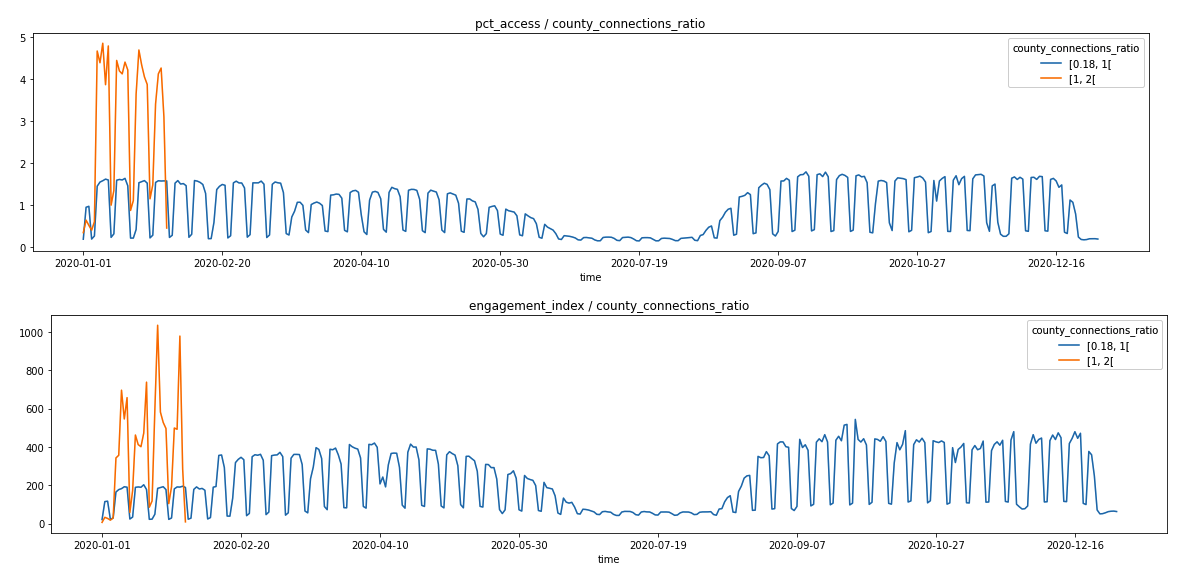
    
__We can expect that the higher the digital connenctivity get, the greater the engagement would be.__
    
    
        
#### 2. What is the effect of the COVID-19 pandemic on online and distance learning, and how might this also evolve in the future?  
    
Although the percentages of 'pct_access' are always high and do not change significantly throughout the year,
the values of 'engagement_index' is on a gradual upper trend.
    
It means that throughout the year ｔhere has been no significant change in the number of users, but the amount of uses by each person has increased. 
    
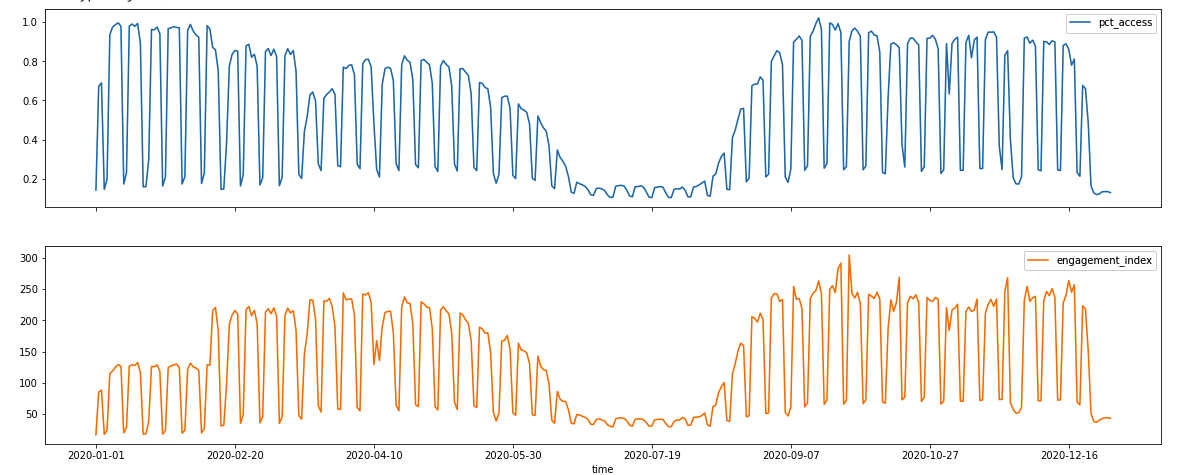
        
__We can expect that the COVID-19 pandemic encourage pupils to do on online and distance learning more.__
    
Furthermore, There is a big difference in 'engagement_index' depending on the 'state'.
In addition to it,
    
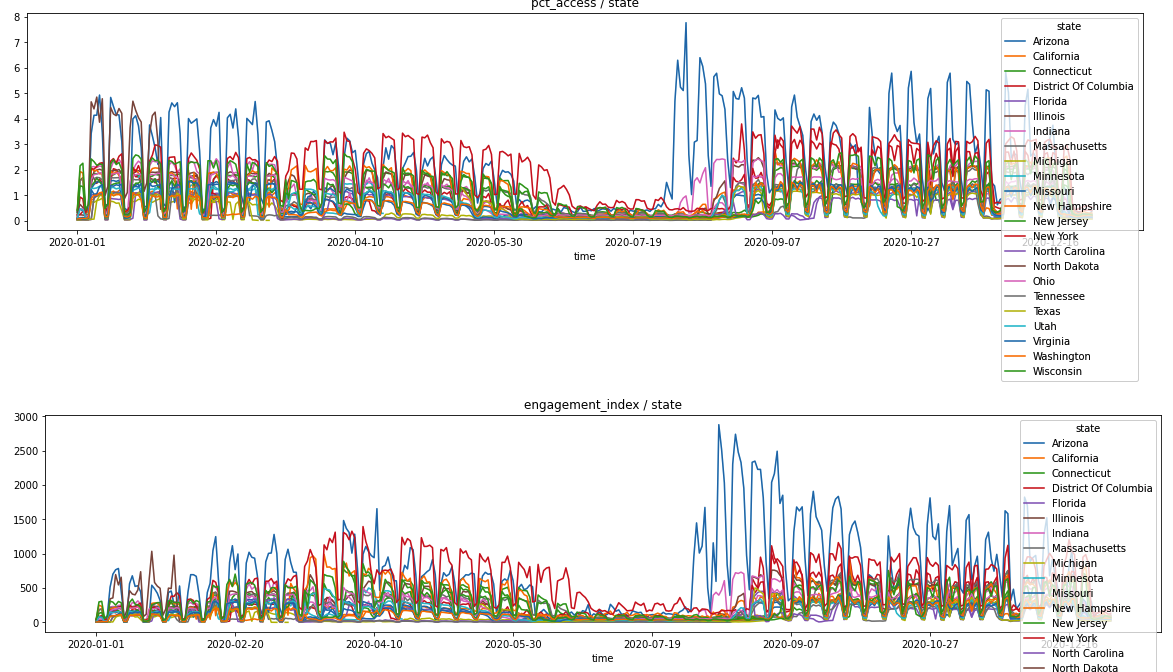
    
And also, the engagements would be grater, when each value of 'pct_black/hispanic' and 'pct_free/reduced' is higher.
   
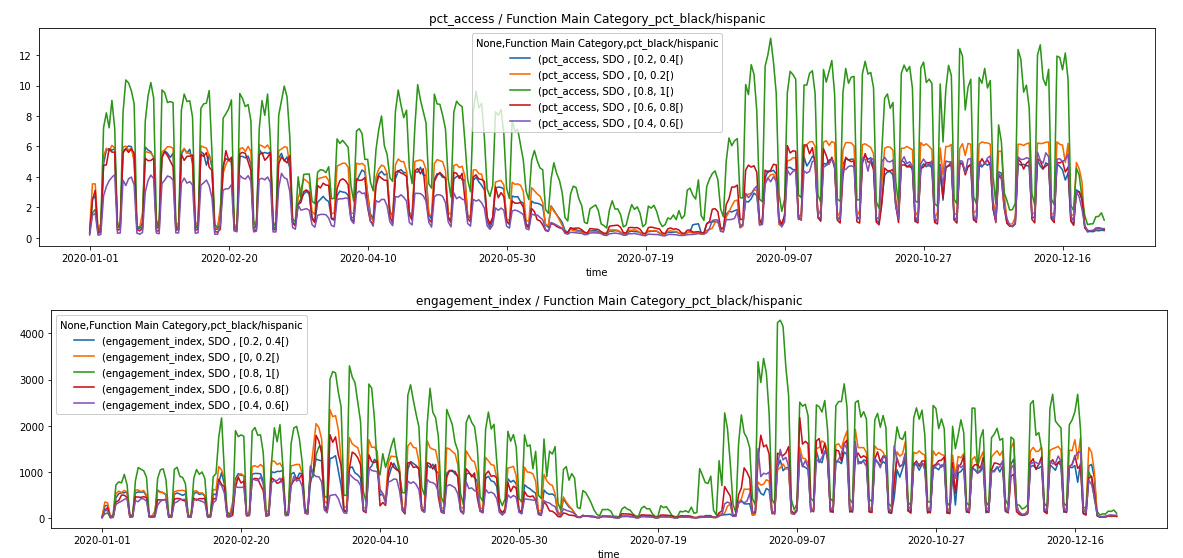
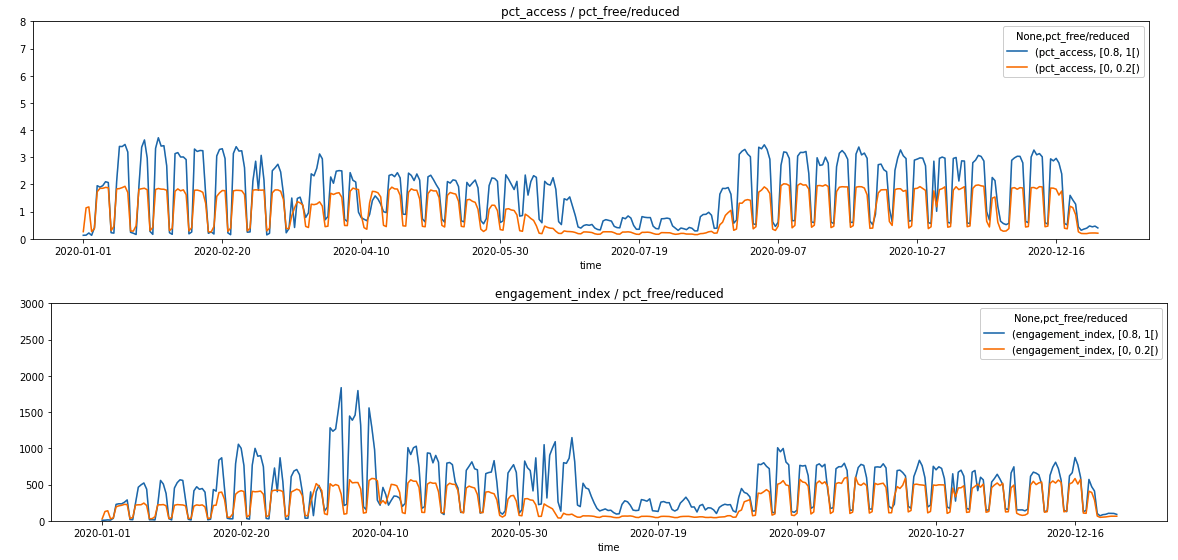
    
__We can expect that an increase in 'pct_free/reduced' encourage pupils to do on online and distance learning more__ though there are correlation between'pct_black/hispanic' and 'pct_free/reduced'.
        
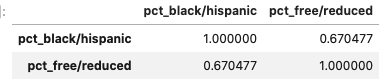

#### 3. How does student engagement with different types of education technology change over the course of the pandemic?

The engagements of CM (Classroom Management) and SDO (School & District Operations)　A and B  is increasing. In particular, as can be seen from the fact that the lower bound has been raised, it can be said that the number of people who engage in daily activities has increased due to the pandemic.

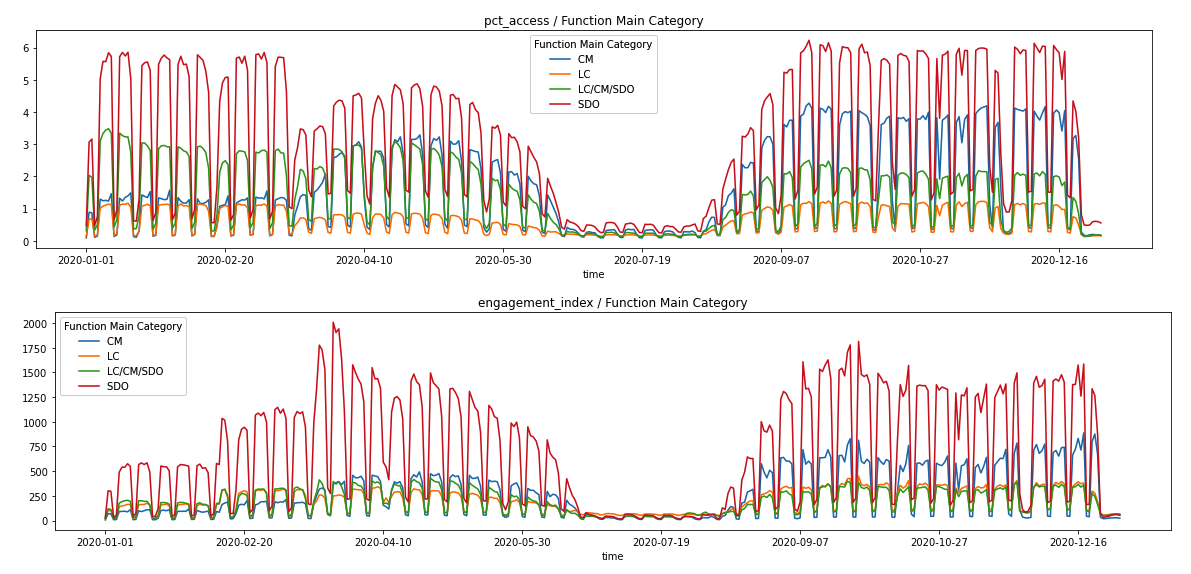

#### 4. How does student engagement with online learning platforms relate to different geography? Demographic context (e.g., race/ethnicity, ESL, learning disability)?  Learning context? Socioeconomic status?

About 'pct_black/hispanic' and 'pct_free/reduced', please refer the analysis for 2.

About the 'state' which have the highest engagement, we can see that 'Rural' is the categories that result in the lowest engagement, and that 'City' is the categories that result in the lowest engagement.

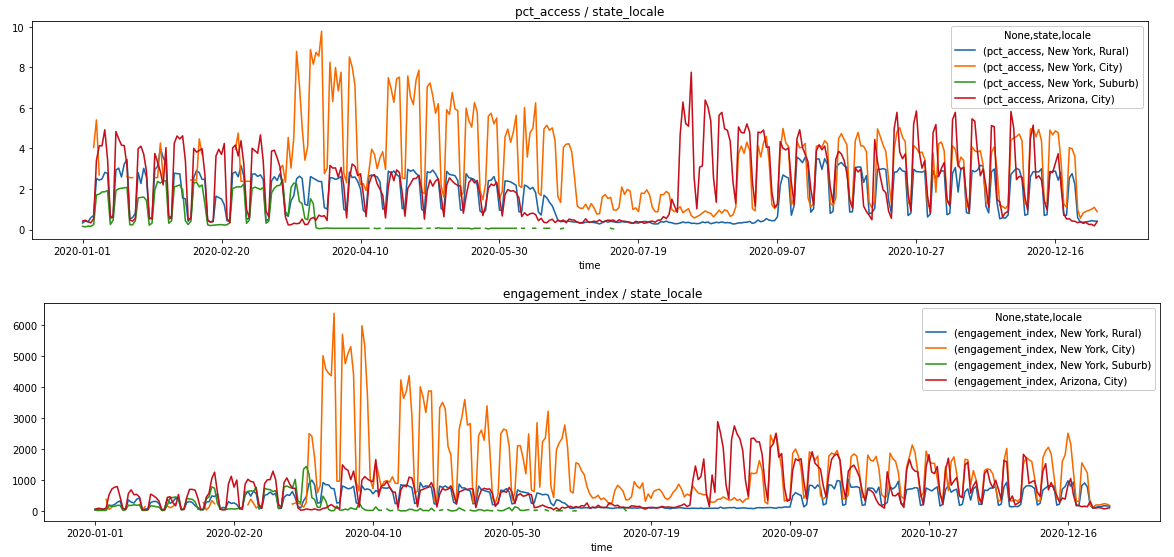

__We can expect that the engagement would be greater, where the areas with high contact with other companies and exposed to pandemic threats.

#### 5. Do certain state interventions, practices or policies (e.g., stimulus, reopening, eviction moratorium) correlate with the increase or decrease online engagement?

##### Decrease in engagement in North Carolina 
According to [North Carolina covid-19-guidance](https://www.huschblackwell.com/north-carolina-state-by-state-covid-19-guidance), the declaration a state of emergency in March seems to be a reason the decrease of engagements. Also, in September 21, the announce that beginning on October 5, North Carolina public school districts and charter schools can choose to implement Plan A for elementary schools (grades K-5) seems to be a reason of the restart of engagements.

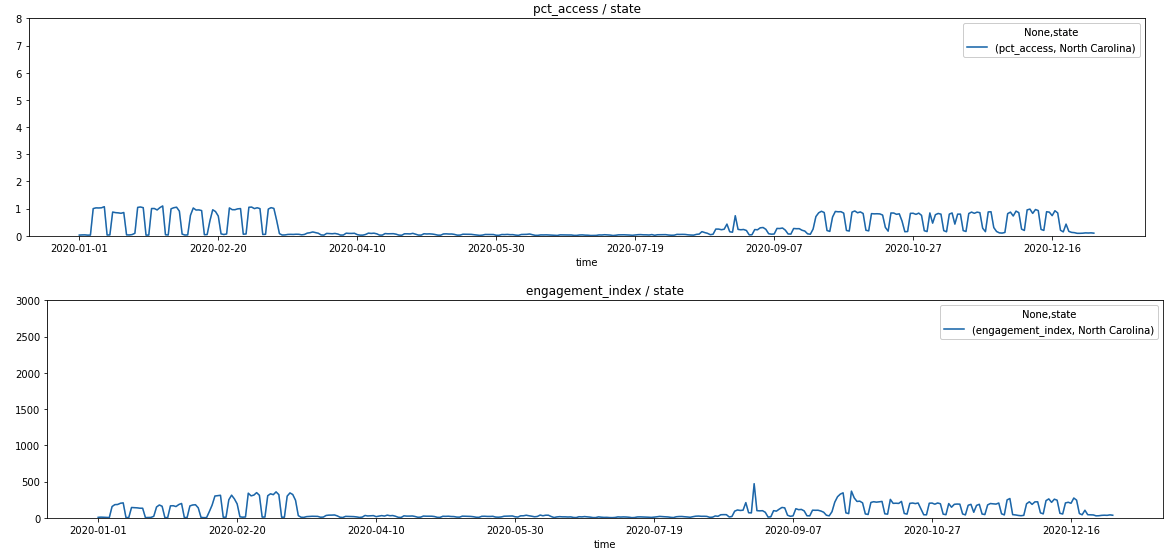

##### Increase in engagement in North Carolina 
According to [The New York Times](https://www.nytimes.com/2020/05/07/business/school-education-online-money.html)

> For most children, the school year effectively ended in March.

The timing of the end of the school year coincides with the timing of the explosive increase in the engagement in the 'City'. This suggests that the characteristics of the 'City' (large number of people, relatively wealthy, large amount of information transmitted by people, etc.) have an effect on the increase in engagement.

According to [Arizonna covid-19-guidance](https://www.huschblackwell.com/arizona-state-by-state-covid-19-guidance) on July 27,

> Schools will still be required to provide 180 days of instruction or the equivalent hours, however distance learning instruction counts toward the minimum instructional days or equivalent number of hours statutorily required. School districts and charter schools must begin teacher-led distance learning by the first day of the school district or charter school’s instructional calendar, and schools must begin offering free on-site learning opportunities and support services for students who need a place to go during the day, starting August 17, 2020.

This instruction seems to cause a surge in Arizona's engagement around August.

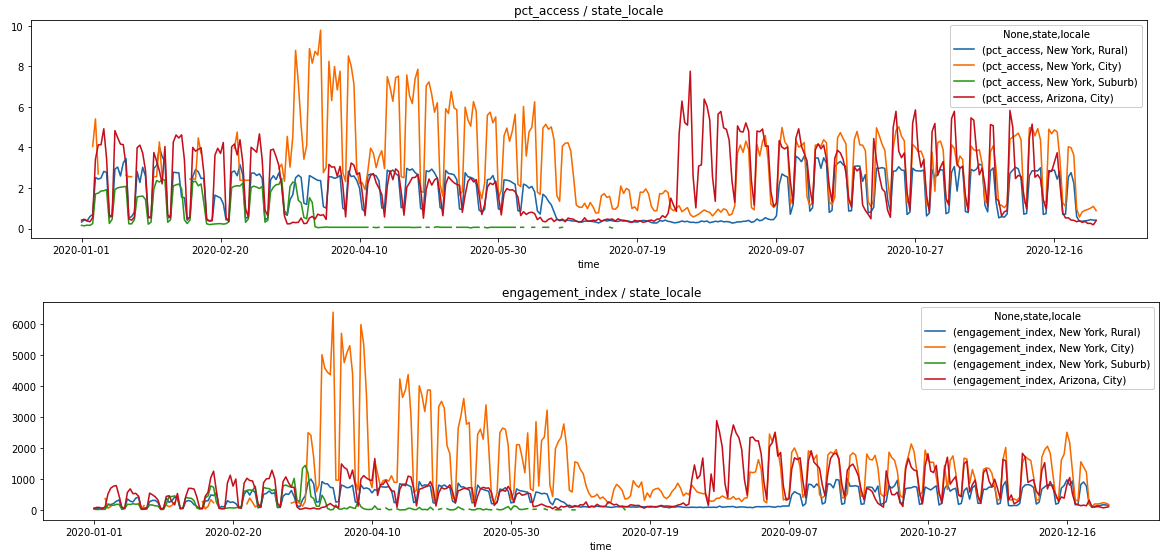

## More Simple Summarry

The following factors is expected to lead to the _more_ increase in the engagements of online or distance learning from above analysis than the other factors.

+ High rate of Black or Hispanic
+ High rate of students who can have free or reduced-price lunch 
+ More than 20000 of per-pupil total expenditure (sum of local and federal expenditure) from Edunomics Lab's National Education Resource Database on Schools (NERD$) project.
+ School & District Operations (The announsments, policies, and instractions for epidemic prevention　in each district).
+ The characteristics of the 'City' (large number of people, relatively wealthy, large amount of information transmitted by people, etc).
+ The characteristics of 'Sector(s)" of the 'Corporate'
